## Reproduce results from “Modeling BBR’s Interactions with Loss-Based Congestion Control”

This notebook will reproduce selected findings from

> Ranysha Ware, Matthew K. Mukerjee, Srinivasan Seshan, and Justine Sherry. 2019. Modeling BBR’s Interactions with Loss-Based Congestion Control. In Proceedings of the Internet Measurement Conference (IMC ’19). Association for Computing Machinery, New York, NY, USA, 137–143. https://doi.org/10.1145/3355369.3355604

specifically,

-   Figure 1b and 1c (initial measurements of BBR’s empirical behaviors)
-   Figure 2: BBR vs Cubic in a 40ms × 10Mbps network (convergence time and goodput for 1 BBR and 1 Cubic flow over varying queue sizes)
-   Figure 3: BBR and Cubic or Reno’s queue when competing for 4 minutes over a network with a 64 BDP (1024 packet) queue

The following group of cells installs prerequisites for data analysis and visualization:

In [1]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import time
import pandas as pd
from io import StringIO
import seaborn as sns 
import matplotlib.pyplot as plt

### Configure environment

In [3]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,fbs6417_0000066146
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


### Define configuration for this experiment

In [4]:
slice_name="ware-" + fablib.get_bastion_username()

node_conf = [
 {'name': "sender",    'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_22', 'packages': ['iperf3']}, 
 {'name': "receiver",  'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_22', 'packages': ['iperf3']}, 
 {'name': "router",    'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_22', 'packages': []}
]
net_conf = [
 {"name": "net0", "subnet": "10.0.0.0/24", "nodes": [{"name": "sender",   "addr": "10.0.0.100"}, {"name": "router", "addr": "10.0.0.1"}]},
 {"name": "net1", "subnet": "10.0.1.0/24", "nodes": [{"name": "receiver", "addr": "10.0.1.100"}, {"name": "router", "addr": "10.0.1.1"}]},
]
route_conf = [
 {"addr": "10.0.1.0/24", "gw": "10.0.0.1", "nodes": ["sender"]}, 
 {"addr": "10.0.0.0/24", "gw": "10.0.1.1", "nodes": ["receiver"]}
]
exp_conf = {'cores': sum([ n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf]) }

### Reserve resources

Now, we are ready to reserve resources!

First, make sure you don’t already have a slice with this name:

In [5]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You already have a slice by this name!
If you previously reserved resources, skip to the 'log in to resources' section.


We will select a random site that has sufficient resources for our experiment:

In [6]:
while True:
    site_name = fablib.get_random_site()
    if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_conf['cores']) and
        (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_conf['nic']) ):
        break

fablib.show_site(site_name)

Name,DALL
State,Active
Address,"1950 N Stemmons Fwy,Dallas TX 75207"
Location,"(32.79908160563668, -96.82069027727609)"
PTP Capable,False
Hosts,3
CPUs,6
Cores Available,154
Cores Capacity,384
Cores Allocated,230
RAM Available,952


'<pandas.io.formats.style.Styler object at 0x7fa006164820>'

Then we will add hosts and network segments:

In [7]:
# this cell sets up the nodes
for n in node_conf:
    slice.add_node(name=n['name'], site=site_name, 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [8]:
# this cell sets up the network segments
for n in net_conf:
    ifaces = [slice.get_node(node["name"]).add_component(model="NIC_Basic", 
                                                 name=n["name"]).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

The following cell submits our request to the FABRIC site. The output of this cell will update automatically as the status of our request changes.

-   While it is being prepared, the “State” of the slice will appear as “Configuring”.
-   When it is ready, the “State” of the slice will change to “StableOK”.

You may prefer to walk away and come back in a few minutes (for simple slices) or a few tens of minutes (for more complicated slices with many resources).

In [9]:
slice.submit()


Retry: 10, Time: 313 sec


ID,d31c01ca-2db3-4eb0-9e80-7a29d4f391c8
Name,ware-fbs6417_0000066146
Lease Expiration (UTC),2024-04-26 22:27:15 +0000
Lease Start (UTC),2024-04-25 22:27:16 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
5d34da6e-d0d5-4ec9-964d-168ce087eaab,receiver,2,4,10,default_ubuntu_22,qcow2,dall-w1.fabric-testbed.net,DALL,ubuntu,2001:400:a100:3000:f816:3eff:fe13:f42a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fe13:f42a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
0847124e-3356-40a2-adcf-7d608cb1a8e2,router,2,4,10,default_ubuntu_22,qcow2,dall-w1.fabric-testbed.net,DALL,ubuntu,2001:400:a100:3000:f816:3eff:fe0d:4735,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fe0d:4735,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
a47f184e-c88c-4354-adea-cfb03cdccf27,sender,2,4,10,default_ubuntu_22,qcow2,dall-w1.fabric-testbed.net,DALL,ubuntu,2001:400:a100:3000:f816:3eff:fedd:9bf,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fedd:9bf,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
99ca6328-1d86-483e-8575-016701dc9a8a,net0,L2,L2Bridge,DALL,None,None,Active,
0a116aeb-49fb-4c10-870f-98ce2c867af5,net1,L2,L2Bridge,DALL,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
sender-net0-p1,p1,sender,net0,100,config,,3E:5B:19:47:15:63,enp7s0,enp7s0,None,6
receiver-net1-p1,p1,receiver,net1,100,config,,3A:66:3D:AE:2B:BF,enp7s0,enp7s0,None,6
router-net0-p1,p1,router,net0,100,config,,4A:BB:14:67:C6:EF,enp8s0,enp8s0,None,6
router-net1-p1,p1,router,net1,100,config,,3E:8C:63:2C:CE:7E,enp7s0,enp7s0,None,6



Time to print interfaces 319 seconds


'd31c01ca-2db3-4eb0-9e80-7a29d4f391c8'

In [10]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

### Extend your slice

If you don’t plan to finish an experiment in one day, you can extend your slice. The following cell extends your reservation for 7 days.

In [6]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta

# Set end date to 7 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=7)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)

### Configure resources

Next, we will configure the resources so they are ready to use.

In [12]:
slice = fablib.get_slice(name=slice_name)

In [13]:
# install packages
# this will take a while and will run in background while you do other steps
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo DEBIAN_FRONTEND=noninteractive apt -y install %s" % pkg)

In [14]:
# bring interfaces up and either assign an address (if there is one) or flush address
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [15]:
# make sure all interfaces are brought up
for iface in slice.get_interfaces():
    iface.ip_link_up()

In [16]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    for h in hosts_txt:
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)

10.0.0.100 sender
10.0.0.1 router
10.0.1.100 receiver
10.0.1.1 router
10.0.0.100 sender
10.0.0.1 router
10.0.1.100 receiver
10.0.1.1 router
10.0.0.100 sender
10.0.0.1 router
10.0.1.100 receiver
10.0.1.1 router


In [17]:
# enable IPv4 forwarding on all nodes
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


In [18]:
# set up static routes
for rt in route_conf:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

In [19]:
# turn off segmentation offload on interfaces
for iface in slice.get_interfaces():
    iface_name = iface.get_device_name()
    n = iface.get_node()
    offloads = ["gro", "lro", "gso", "tso"]
    for offload in offloads:
        n.execute("sudo ethtool -K %s %s off" % (iface_name, offload))

### Validate base network

Before we run any experiment, we should check the “base” network - before adding any emulated delay or rate limiting - and make sure that it will not be a limiting factor in the experiment.

In [20]:
# check base delay
_ = slice.get_node("sender").execute("ping -c 5 receiver")

PING receiver (10.0.1.100) 56(84) bytes of data.
64 bytes from receiver (10.0.1.100): icmp_seq=1 ttl=63 time=0.561 ms
64 bytes from receiver (10.0.1.100): icmp_seq=2 ttl=63 time=0.103 ms
64 bytes from receiver (10.0.1.100): icmp_seq=3 ttl=63 time=0.098 ms
64 bytes from receiver (10.0.1.100): icmp_seq=4 ttl=63 time=0.114 ms
64 bytes from receiver (10.0.1.100): icmp_seq=5 ttl=63 time=0.099 ms

--- receiver ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4088ms
rtt min/avg/max/mdev = 0.098/0.195/0.561/0.183 ms


In [21]:
# check base capacity (by sending 10 parallel flows, look at their sum throughput)
import time
_ = slice.get_node("receiver").execute("iperf3 -s -1 -D")
time.sleep(5)
_ = slice.get_node("sender").execute("iperf3 -t 30 -i 10 -P 10 -c receiver")

Connecting to host receiver, port 5201
[  5] local 10.0.0.100 port 48424 connected to 10.0.1.100 port 5201
[  7] local 10.0.0.100 port 48426 connected to 10.0.1.100 port 5201
[  9] local 10.0.0.100 port 48436 connected to 10.0.1.100 port 5201
[ 11] local 10.0.0.100 port 48446 connected to 10.0.1.100 port 5201
[ 13] local 10.0.0.100 port 48456 connected to 10.0.1.100 port 5201
[ 15] local 10.0.0.100 port 48468 connected to 10.0.1.100 port 5201
[ 17] local 10.0.0.100 port 48480 connected to 10.0.1.100 port 5201
[ 19] local 10.0.0.100 port 48492 connected to 10.0.1.100 port 5201
[ 21] local 10.0.0.100 port 48504 connected to 10.0.1.100 port 5201
[ 23] local 10.0.0.100 port 48514 connected to 10.0.1.100 port 5201
[ ID] Interval           Transfer     Bitrate         Retr  Cwnd
[  5]   0.00-10.00  sec  1001 MBytes   840 Mbits/sec  247    168 KBytes       
[  7]   0.00-10.00  sec   914 MBytes   767 Mbits/sec  374    167 KBytes       
[  9]   0.00-10.00  sec  1.04 GBytes   897 Mbits/sec  234 

In [22]:
# also check Linux kernel version on sender
_ = slice.get_node("sender").execute("uname -a")

Linux sender 5.15.0-91-generic #101-Ubuntu SMP Tue Nov 14 13:30:08 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux


### Draw the network topology

The following cell will draw the network topology, for your reference. The interface name and addresses of each experiment interface will be shown on the drawing.

In [23]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

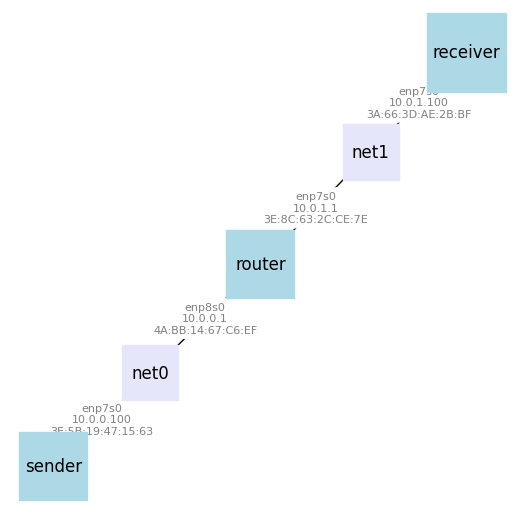

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

### Log into resources

Now, we are finally ready to log in to our resources over SSH! Run the following cells, and observe the table output - you will see an SSH command for each of the resources in your topology.

In [25]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
sender,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fedd:9bf
receiver,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fe13:f42a
router,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fe0d:4735


Now, you can open an SSH session on any of the resources as follows:

-   in Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   copy an SSH command from the table, and paste it into the terminal. (Note that each SSH command is a single line, even if the display wraps the text to a second line! When you copy and paste it, paste it all together.)

You can repeat this process (open several terminals) to start a session on each resource. Each terminal session will have a tab in the Jupyter environment, so that you can easily switch between them.

### Configure the network capacity and delay

In this section, we configure the bottleneck link to have a 40Mbps capacity and 10ms delay. We will initialize the queue size to 32 BDP (although we will change this later).

In [47]:
exp = {'rtt': 40, 'bandwidth': 10 }
bdp_kbyte = exp['rtt']*exp['bandwidth']/8

router_node = slice.get_node("router")
router_ingress_iface = router_node.get_interface(network_name = "net0")
router_ingress_name = router_ingress_iface.get_device_name()
router_egress_iface  = router_node.get_interface(network_name = "net1")
router_egress_name = router_egress_iface.get_device_name()

router_node.execute("sudo tc qdisc del dev " + router_ingress_name + " root")
router_node.execute("sudo tc qdisc del dev " + router_egress_name + " root")

# set up RTT
router_node.execute("sudo tc qdisc replace dev " + router_ingress_name + " root netem delay " + str(exp['rtt']) + "ms limit 10000")
# set up rate limit, buffer limit
router_node.execute("sudo tc qdisc replace dev " + router_egress_name + " root handle 1: htb default 3")
router_node.execute("sudo tc class add dev " + router_egress_name + " parent 1: classid 1:3 htb rate " + str(exp['bandwidth']) + "Mbit")
router_node.execute("sudo tc qdisc add dev " + router_egress_name + " parent 1:3 bfifo limit " + str(bdp_kbyte*32) + "kb")


('', '')

Then, we validate the new network setting.

In [48]:
# check base delay
_ = slice.get_node("sender").execute("ping -c 5 receiver")

PING receiver (10.0.1.100) 56(84) bytes of data.
64 bytes from receiver (10.0.1.100): icmp_seq=1 ttl=63 time=40.4 ms
64 bytes from receiver (10.0.1.100): icmp_seq=2 ttl=63 time=40.2 ms
64 bytes from receiver (10.0.1.100): icmp_seq=3 ttl=63 time=40.1 ms
64 bytes from receiver (10.0.1.100): icmp_seq=4 ttl=63 time=40.1 ms
64 bytes from receiver (10.0.1.100): icmp_seq=5 ttl=63 time=40.1 ms

--- receiver ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4005ms
rtt min/avg/max/mdev = 40.124/40.181/40.360/0.089 ms


In [27]:
# check base capacity (by sending 10 parallel flows, look at their sum throughput)
import time
_ = slice.get_node("receiver").execute("iperf3 -s -1 -D")
time.sleep(5)
_ = slice.get_node("sender").execute("iperf3 -t 30 -i 10 -P 10 -c receiver")

Connecting to host receiver, port 5201
[  5] local 10.0.0.100 port 51788 connected to 10.0.1.100 port 5201
[  7] local 10.0.0.100 port 51796 connected to 10.0.1.100 port 5201
[  9] local 10.0.0.100 port 51802 connected to 10.0.1.100 port 5201
[ 11] local 10.0.0.100 port 51814 connected to 10.0.1.100 port 5201
[ 13] local 10.0.0.100 port 51826 connected to 10.0.1.100 port 5201
[ 15] local 10.0.0.100 port 51840 connected to 10.0.1.100 port 5201
[ 17] local 10.0.0.100 port 51844 connected to 10.0.1.100 port 5201
[ 19] local 10.0.0.100 port 51854 connected to 10.0.1.100 port 5201
[ 21] local 10.0.0.100 port 51862 connected to 10.0.1.100 port 5201
[ 23] local 10.0.0.100 port 51866 connected to 10.0.1.100 port 5201
[ ID] Interval           Transfer     Bitrate         Retr  Cwnd
[  5]   0.00-10.00  sec  2.08 MBytes  1.74 Mbits/sec   62    178 KBytes       
[  7]   0.00-10.00  sec  2.01 MBytes  1.69 Mbits/sec   58    177 KBytes       
[  9]   0.00-10.00  sec  2.27 MBytes  1.90 Mbits/sec   53 

### Reproduce Figure 1b

In [6]:
router_node = slice.get_node("router")
sender_node = slice.get_node("sender")
receiver_node = slice.get_node("receiver")

In [7]:
import itertools
exp_factors = { 
    'bufcap': [0.25, 0.5] + [2**n for n in range(8)],
    #'bufcap': [0.25],
    'duration': [240],
    'loss_cc': ['cubic', 'reno'],
    #'loss_cc': ['cubic'],
    'trial': [1]
}
factor_names = [k for k in exp_factors]
factor_lists = list(itertools.product(*exp_factors.values()))
exp_lists = [dict(zip(factor_names, factor_l)) for factor_l in factor_lists]

In [8]:
exp_lists

[{'bufcap': 0.25, 'duration': 240, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 0.25, 'duration': 240, 'loss_cc': 'reno', 'trial': 1},
 {'bufcap': 0.5, 'duration': 240, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 0.5, 'duration': 240, 'loss_cc': 'reno', 'trial': 1},
 {'bufcap': 1, 'duration': 240, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 1, 'duration': 240, 'loss_cc': 'reno', 'trial': 1},
 {'bufcap': 2, 'duration': 240, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 2, 'duration': 240, 'loss_cc': 'reno', 'trial': 1},
 {'bufcap': 4, 'duration': 240, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 4, 'duration': 240, 'loss_cc': 'reno', 'trial': 1},
 {'bufcap': 8, 'duration': 240, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 8, 'duration': 240, 'loss_cc': 'reno', 'trial': 1},
 {'bufcap': 16, 'duration': 240, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 16, 'duration': 240, 'loss_cc': 'reno', 'trial': 1},
 {'bufcap': 32, 'duration': 240, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 32, 'du

In [67]:
import time

# make sure BBR is available
sender_node.execute("sudo modprobe tcp_bbr")
receiver_node.execute("sudo modprobe tcp_bbr")

for exp in exp_lists:
    print("Running:",exp)
    sender_node.execute("sudo modprobe tcp_bbr")
    # set router buffer limit 
    router_node.execute("sudo tc qdisc replace dev " + router_egress_name + " parent 1:3 bfifo limit " + str(bdp_kbyte*exp['bufcap']) + "kb")

    # clean up
    receiver_node.execute("sudo killall iperf3")
    sender_node.execute("sudo killall iperf3")
    
    time.sleep(5) 
    
    # start an iperf3 receiver for the BBR flow
    receiver_node.execute_thread("iperf3 -s -1 -i 1 -fm --logfile fig1b_bbr_" + str(exp['bufcap']) + "_bbrV" + exp['loss_cc'] + ".txt")
    #receiver_node.execute("iperf3 -s -D -1 -i 1 -fm --logfile fig1b_bbr_" + str(exp['bufcap']) + "_bbrV" + exp['loss_cc'] + ".txt")
    # start an iperf3 receiver for the loss based CC flows (Cubic & Reno)
    receiver_node.execute_thread("iperf3 -s -1 -i 1 -fm --logfile fig1b_" + exp['loss_cc'] + "_" + str(exp['bufcap']) + "_bbrV" + exp['loss_cc'] + ".txt -p 5301")
    #receiver_node.execute("iperf3 -s -D -1 -i 1 -fm --logfile fig1b_" + exp['loss_cc'] + "_" + str(exp['bufcap']) + "_bbrV" + exp['loss_cc'] + ".txt -p 5301")

    time.sleep(10) 

    # start an iperf3 sender for the BBR flow
    sender_node.execute_thread("iperf3 -c receiver -fm -t " + str(exp['duration']) + " -C bbr ")
    # start an iperf3 sender for the loss based CC flows (Cubic & Reno)
    sender_node.execute_thread("iperf3 -c receiver -fm -t " + str(exp['duration']) + " -C " + exp['loss_cc'] + " -p 5301")

    time.sleep(exp['duration'] + 10)
    
print("done")

Running: {'bufcap': 0.25, 'duration': 240, 'loss_cc': 'cubic', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 Running: {'bufcap': 0.25, 'duration': 240, 'loss_cc': 'reno', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 Running: {'bufcap': 0.5, 'duration': 240, 'loss_cc': 'cubic', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 Running: {'bufcap': 0.5, 'duration': 240, 'loss_cc': 'reno', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 Running: {'bufcap': 1, 'duration': 240, 'loss_cc': 'cubic', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 Running: {'bufcap': 1, 'duration': 240, 'loss_cc': 'reno', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 Running: {'bufcap': 2, 'duration': 240, 'loss_cc': 'cubic', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 Running: {'bufcap': 2, 'duration': 240, 'loss_cc': 'reno', 'trial': 1}
 iperf3: no process found
  iperf3: no p

In [12]:
df = pd.DataFrame(columns=['bufcap', 'combo', 'cc', 'goodput'])
for exp in exp_lists:

    bbr_file = "fig1b_bbr_" + str(exp['bufcap']) + "_bbrV" + exp['loss_cc'] + ".txt"
    tput_bbr = receiver_node.execute("cat /home/ubuntu/figure1b/" + bbr_file + " | grep 'receiver' | awk -F '-' '{print $2}' | awk '{print $5}'", quiet=True)
    df_dict = {'bufcap': exp['bufcap'], 'combo': "BBR-" + exp['loss_cc'], 'cc': 'BBR', 'goodput': float(tput_bbr[0].strip())}
    df = pd.concat([df, pd.DataFrame(df_dict, index=[0])], ignore_index=True)

    loss_file = "fig1b_" + exp['loss_cc'] + "_" + str(exp['bufcap']) + "_bbrV" + exp['loss_cc'] + ".txt"
    tput_loss = receiver_node.execute("cat /home/ubuntu/figure1b/" + loss_file + " | grep 'receiver' | awk -F '-' '{print $2}' | awk '{print $5}'", quiet=True)
    df_dict = {'bufcap': exp['bufcap'], 'combo': "BBR-" + exp['loss_cc'], 'cc': exp['loss_cc'], 'goodput': float(tput_loss[0].strip())}
    df = pd.concat([df, pd.DataFrame(df_dict, index=[0])], ignore_index=True)

/tmp/ipykernel_153/110088611.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(df_dict, index=[0])], ignore_index=True)


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


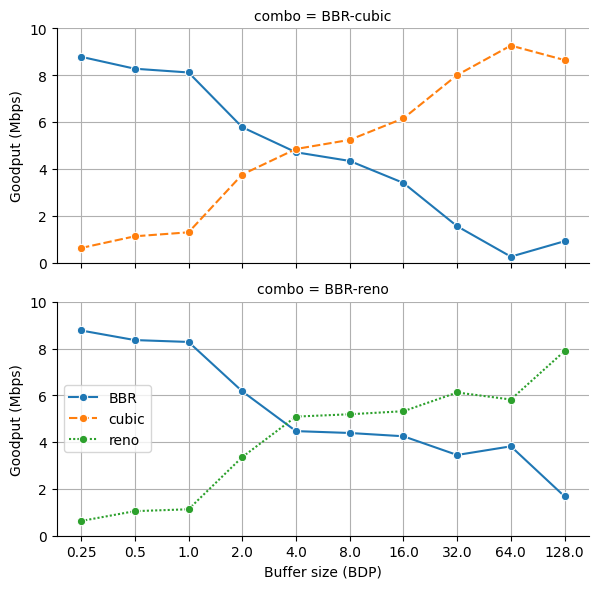

In [13]:
df['buf_str'] = df['bufcap'].astype(str)
g = sns.FacetGrid(df, row="combo", legend_out=True, aspect=2);
g = g.map(sns.lineplot, "buf_str", "goodput",  hue=df.cc, style=df.cc, markers="o", markersize=6);
g.set_axis_labels("Buffer size (BDP)", "Goodput (Mbps)");
g.set(ylim=(0, 10))
g.axes.flat[0].grid(True)
g.axes.flat[1].grid(True)
plt.legend();

### Reproduce Figure 1c

In [108]:
router_node = slice.get_node("router")
sender_node = slice.get_node("sender")
receiver_node = slice.get_node("receiver")

In [109]:
# set router buffer limit to 32 BDP
router_node.execute("sudo tc qdisc replace dev " + router_egress_name + " parent 1:3 bfifo limit " + str(bdp_kbyte*32) + "kb")

# make sure BBR is available
sender_node.execute("sudo modprobe tcp_bbr")

# clean up
receiver_node.execute("sudo killall iperf3")
receiver_node.execute("rm fig1c_bbr.txt")
receiver_node.execute("rm fig1c_cubic.txt")

# start an iperf3 receiver for the BBR flow
receiver_node.execute_thread("iperf3 -s -1 -i 1 -fm --logfile fig1c_bbr.txt")
# start an iperf3 receiver for the Cubic flows
receiver_node.execute_thread("iperf3 -s -1 -i 1 -fm --logfile fig1c_cubic.txt -p 5301")

time.sleep(5) 

# start an iperf3 sender for the BBR flow
sender_node.execute_thread("iperf3 -c receiver -fm -t 300 -C bbr ")
# start an iperf3 receiver for the Cubic flows
sender_node.execute_thread("iperf3 -c receiver -fm -t 300 -C cubic -P 16 -p 5301")

time.sleep(305)

 iperf3: no process found
  rm: cannot remove 'fig1c_bbr.txt': No such file or directory
  rm: cannot remove 'fig1c_cubic.txt': No such file or directory
 

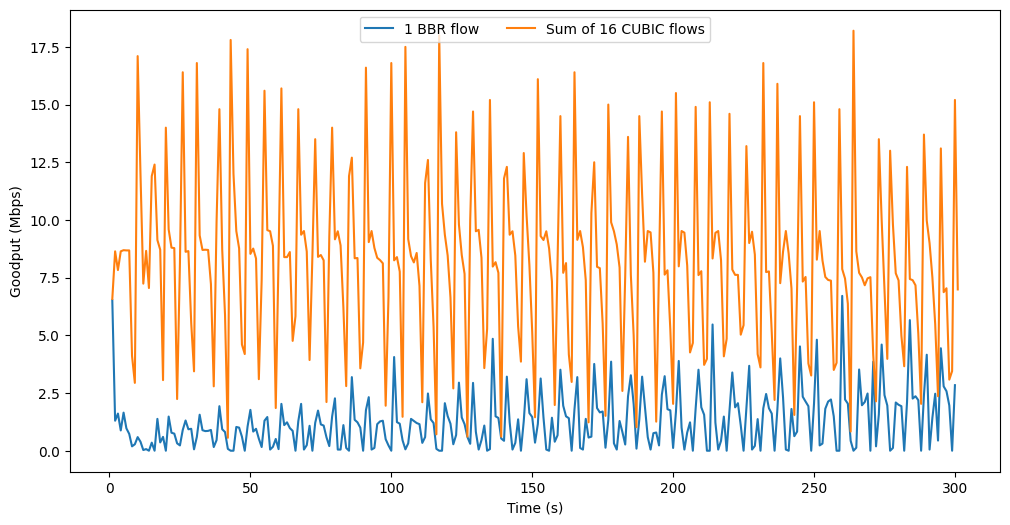

In [16]:
tput_bbr = receiver_node.execute("head --lines=-5 /home/ubuntu/figure1c/fig1c_bbr.txt | grep 'Mbits/sec' | awk -F '-' '{print $2}' | awk '{print $1\",\"$5}'", quiet=True)
df_bbr = pd.read_csv(StringIO(tput_bbr[0]), names = ['time','goodput'])

tput_cubic = receiver_node.execute("head --lines=-37 /home/ubuntu/figure1c/fig1c_cubic.txt | grep 'SUM' | awk -F '-' '{print $2}' | awk '{print $1\",\"$5}'", quiet=True)
df_cubic = pd.read_csv(StringIO(tput_cubic[0]), names = ['time','goodput'])

_ = plt.figure(figsize=(12,6))
_ = plt.plot(df_bbr.time, df_bbr.goodput, label="1 BBR flow")
_ = plt.plot(df_cubic.time, df_cubic.goodput, label="Sum of 16 CUBIC flows")
_ = plt.legend(loc="upper center", ncol=2)
_ = plt.ylabel("Goodput (Mbps)")
_ = plt.xlabel("Time (s)")

### Reproduce Figure 2a

In [55]:
router_node = slice.get_node("router")
sender_node = slice.get_node("sender")
receiver_node = slice.get_node("receiver")

In [56]:
import itertools
exp_factors = { 
    'bufcap': [2**n for n in range(7)],
    'duration': [660],
    'loss_cc': ['cubic'],
    'trial': [1]
}
factor_names = [k for k in exp_factors]
factor_lists = list(itertools.product(*exp_factors.values()))
exp_lists = [dict(zip(factor_names, factor_l)) for factor_l in factor_lists]

In [57]:
exp_lists

[{'bufcap': 1, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 2, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 4, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 8, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 16, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 32, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1},
 {'bufcap': 64, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1}]

In [58]:
import time

# make sure BBR is available
sender_node.execute("sudo modprobe tcp_bbr")
receiver_node.execute("sudo modprobe tcp_bbr")

for exp in exp_lists:
    print("Running:",exp)
    sender_node.execute("sudo modprobe tcp_bbr")
    # set router buffer limit 
    router_node.execute("sudo tc qdisc replace dev " + router_egress_name + " parent 1:3 bfifo limit " + str(bdp_kbyte*exp['bufcap']) + "kb")

    # clean up
    receiver_node.execute("sudo killall iperf3")
    sender_node.execute("sudo killall iperf3")
    
    time.sleep(5) 
    
    # start an iperf3 receiver for the BBR flow
    receiver_node.execute_thread("iperf3 -s -1 -i 1 -fm --logfile fig2a_bbr_" + str(exp['bufcap']) + "_bbrV" + exp['loss_cc'] + ".txt")
    # start an iperf3 receiver for the loss based CC flows (Cubic & Reno)
    receiver_node.execute_thread("iperf3 -s -1 -i 1 -fm --logfile fig2a_" + exp['loss_cc'] + "_" + str(exp['bufcap']) + "_bbrV" + exp['loss_cc'] + ".txt -p 5301")

    time.sleep(10) 

    # start an iperf3 sender for the BBR flow
    sender_node.execute_thread("iperf3 -c receiver -fm -t " + str(exp['duration']) + " -C bbr ")
    # start an iperf3 sender for the loss based CC flows (Cubic & Reno)
    sender_node.execute_thread("iperf3 -c receiver -fm -t " + str(exp['duration']) + " -C " + exp['loss_cc'] + " -p 5301")

    time.sleep(exp['duration'] + 10)
    
print("done")

Running: {'bufcap': 1, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 Running: {'bufcap': 2, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 Running: {'bufcap': 4, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 Running: {'bufcap': 8, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 Running: {'bufcap': 16, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 Running: {'bufcap': 32, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 Running: {'bufcap': 64, 'duration': 660, 'loss_cc': 'cubic', 'trial': 1}
 iperf3: no process found
  iperf3: no process found
 done


In [62]:
experiment_dfs = {}

for exp in exp_lists:

    bbr_file = "fig2a_bbr_" + str(exp['bufcap']) + "_bbrV" + exp['loss_cc'] + ".txt"
    tput_bbr =  receiver_node.execute("head --lines=-5 /home/ubuntu/figure2a/"+bbr_file+" | grep 'Mbits/sec' | awk -F '-' '{print $2}' | awk '{print $1\",\"$5}'", quiet=True)
    df_bbr = pd.read_csv(StringIO(tput_bbr[0]), names = ['time','goodput'])
    experiment_key = f"bbr_{exp['bufcap']}_{exp['loss_cc']}"
    experiment_dfs[experiment_key] = df_bbr


    loss_file = "fig2a_" + exp['loss_cc'] + "_" + str(exp['bufcap']) + "_bbrV" + exp['loss_cc'] + ".txt"
    tput_loss = receiver_node.execute("head --lines=-5 /home/ubuntu/figure2a/"+loss_file+" | grep 'Mbits/sec' | awk -F '-' '{print $2}' | awk '{print $1\",\"$5}'", quiet=True)
    df_loss = pd.read_csv(StringIO(tput_loss[0]), names = ['time','goodput'])
    experiment_key = f"loss_{exp['bufcap']}_{exp['loss_cc']}"
    experiment_dfs[experiment_key] = df_loss

In [170]:
def find_convergence(df, percentage_change, time_period):
    """
    Find the first time instance when the throughput (goodput) does not change
    by more than X% for T seconds.

    :param df: DataFrame with 'time' and 'goodput' columns
    :param percentage_change: The maximum allowed relative change in goodput (as a percentage)
    :param time_period: The period of time for which we require stability (in seconds)
    :return: The time of convergence, or None if convergence was not found
    """
    # Convert percentage to a proportion
    max_change = percentage_change / 100.0
    
    # Initialize variables
    start_time = df['time'].iloc[0]
    previous_goodput = df['goodput'].iloc[0]
    
    # Iterate over the DataFrame to check for periods of stability
    for i in range(1, len(df)):
        current_time = df['time'].iloc[i]
        current_goodput = df['goodput'].iloc[i]
        
        # Calculate the relative change in goodput
        if previous_goodput != 0:  # To avoid division by zero
            change = abs((current_goodput - previous_goodput) / previous_goodput)
        else:
            change = 0
        
        # If the change is more than the allowed max change, reset the start time
        if change > max_change:
            start_time = current_time
            previous_goodput = current_goodput
        elif (current_time - start_time) >= time_period:
            # If the period of stability is greater than or equal to T seconds, return the start time
            return start_time
    
    # If the loop completes without returning, convergence was not found
    return None

In [64]:
def find_convergence(df, percentage_change, time_period):
    """
    Find the first time instance when the average throughput (goodput) does not change
    by more than X% for at least T seconds.

    :param df: DataFrame with 'time' and 'goodput' columns
    :param percentage_change: The maximum allowed relative change in goodput (as a percentage)
    :param time_period: The period of time for which we require stability (in seconds)
    :return: The time of convergence, or None if convergence was not found
    """
    # Convert percentage to a proportion
    max_change = percentage_change / 100.0

    # Get the initial rolling average
    rolling_avg = df['goodput'].rolling(window=time_period, min_periods=1).mean()

    for i in range(time_period, len(df)):
        # Calculate the percentage change between the current rolling average and the previous period's rolling average
        if rolling_avg[i - time_period] != 0:  # To avoid division by zero
            change = abs((rolling_avg[i] - rolling_avg[i - time_period]) / rolling_avg[i - time_period])
        else:
            change = 0

        # Check if the percentage change is within the threshold
        if change <= max_change:
            # Return the start time of the window where convergence criteria is met
            return df['time'].iloc[i - time_period + 1]

    # If the loop completes without returning, convergence was not found
    return None

In [171]:
X = 0.1
T = 120


convergence_times = {}

for key, df in experiment_dfs.items():
    # Check if the key starts with 'bbr_'
    if key.startswith('bbr_'):
        # Call the find_convergence function with the DataFrame
        convergence_time = find_convergence(df, X, T)
        
        # Store the convergence time in the results dictionary
        convergence_times[key] = convergence_time

In [168]:
convergence_times

{'bbr_1_cubic': 23.0,
 'bbr_2_cubic': 48.0,
 'bbr_4_cubic': 134.0,
 'bbr_8_cubic': 169.0,
 'bbr_16_cubic': 237.0,
 'bbr_32_cubic': 488.0,
 'bbr_64_cubic': 462.0}

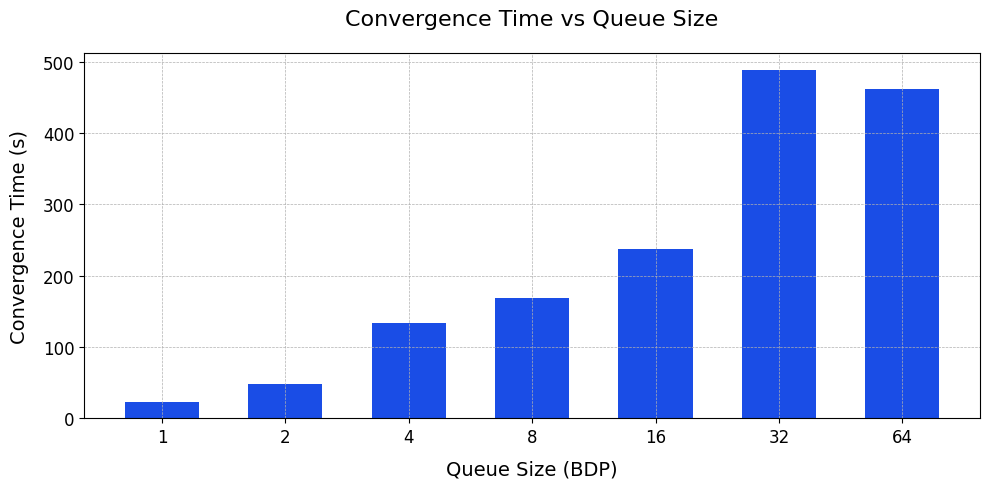

In [169]:
import numpy as np

# Given queue sizes
queue_sizes = [2**n for n in range(7)]

# Extract the convergence times into a list, in the same order as queue_sizes
times = [convergence_times.get(f'bbr_{q}_cubic', 0) for q in queue_sizes]

plt.figure(figsize=(10, 5))
plt.bar(np.log2(queue_sizes), times, color=(0.1, 0.3, 0.9), width=0.6)  # Adjust width for a more compact look
plt.xlabel('Queue Size (BDP)', fontsize=14, labelpad=10)
plt.ylabel('Convergence Time (s)', fontsize=14, labelpad=10)
plt.title('Convergence Time vs Queue Size', fontsize=16, pad=20)
plt.xticks(np.log2(queue_sizes), [str(q) for q in queue_sizes], fontsize=12)  # Ensuring proper tick label formatting
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)  # Adjust grid style
plt.tight_layout()  # Adjust layout to make sure everything fits without overlap
plt.show()

### Delete your slice

When you finish your experiment, you should delete your slice! The following cells deletes all the resources in your slice, freeing them for other experimenters.

In [ ]:
slice = fablib.get_slice(name=slice_name)
fablib.delete_slice(slice_name)

In [ ]:
# slice should end up in "Dead" state
# re-run this cell until you see it in "Dead" state
slice.update()
_ = slice.show()